In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

from jamie import JAMIE
from jamie.evaluation import *
from jamie.utilities import *
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2023-01-17 14:14:10.677423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 14:14:10.760860: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-17 14:14:10.764107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-17 14:14:10.764118: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)
model_folder = './saved_models/'
image_folder = './output_figures/'
output_folder = './output_data/'

In [4]:
import scanpy as sc

babel_dir = '../data/babel_data/DM_rep4/'
train = sc.read_h5ad(babel_dir + 'train_rna.h5ad')
v = train.var_names
train = train.X.toarray()
valid = sc.read_h5ad(babel_dir + 'truth_rna.h5ad').X.toarray()
data1 = np.concatenate([train, valid], axis=0)
fnames1 = np.array(v)

train = sc.read_h5ad(babel_dir + 'train_atac.h5ad')
v = train.var_names
train = train.X.toarray()
valid = sc.read_h5ad(babel_dir + 'truth_atac.h5ad').X.toarray()
data2 = np.concatenate([train, valid], axis=0)
fnames2 = np.array(v)

split = train.shape[0]

/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [5]:
dataset_name = 'DM_rep4'
dataset_color = 'black'
modality_names = ['RNA', 'ATAC']

# data1 = PCA(n_components=32).fit_transform(data1)
# data2 = PCA(n_components=32).fit_transform(data2)
# fnames1 = fnames2 = None

type1 = np.array(len(data1) * ['Cell Type 0'])
type2 = np.array(len(data2) * ['Cell Type 0'])

# Sampling
# sample_num = 500
# data_col_idx = np.random.choice(range(split), sample_num, replace=False)
# data1, data2, type1, type2 = (x[list(data_col_idx) + list(range(split, len(data1)))] for x in (data1, data2, type1, type2))
# split = sample_num

# Labels
labels = [type1, type2]
features = [np.array(fnames1), np.array(fnames2)]
feature_dict = {}

In [6]:
# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
# data1 = preprocessing.MinMaxScaler().fit_transform(data1)
# data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = np.array([f'Feature {i}' for i in range(dataset[i].shape[1])])
        
# # Train-Test Imputation
train_size = split
train_idx = np.array(range(split))
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

# Reduced Priors
full_priors = np.eye(len(dataset[0]))
random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)
none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

In [7]:
reduced_dim = 32
kwargs_imp = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'min_epochs': 2500,
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': 512,
    'pca_dim': 2*[512],
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
}

# JAMIE

In [8]:
# Imputation
size_str, hash_str = hash_kwargs(kwargs_imp, dataset_name, dataset)
prefix = model_folder + 'jm_im---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_im = JAMIE(**kwargs_imp, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_im.fit_transform(dataset=[d[train_idx] for d in dataset])
    jm_im.save_model(model_str)
    np.save(match_str, jm_im.match_result, allow_pickle=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

Loaded model './saved_models/jm_im---DM_rep4---4301-34861---4301-85596.h5'


# Comparison Methods

In [9]:
# Imputation
if True:
    imputation_name = 'Babel'
    bdata1 = sc.read_h5ad(babel_dir + 'atac_rna_test_preds.h5ad').X.toarray()
    bdata2 = sc.read_h5ad(babel_dir + 'rna_atac_test_preds.h5ad').X.toarray()
    nn_imputed = [bdata1, bdata2]
else:
    imputation_name = 'KNN'
    nn_imputed = [predict_knn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i]).float()) for i in range(1, -1, -1)]
# imputed_data_full = [jm_imputed, nn_imputed][::-1]
# imputed_data = [[d[test_idx] for d in ds] for ds in imputed_data_full]
imputed_data = [[d[test_idx] for d in jm_imputed], nn_imputed][::-1]
imputed_names = ['JAMIE', imputation_name][::-1]

# Visualization

In [10]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})
sns.set_palette('husl', len(np.unique(labels)))


KeyboardInterrupt



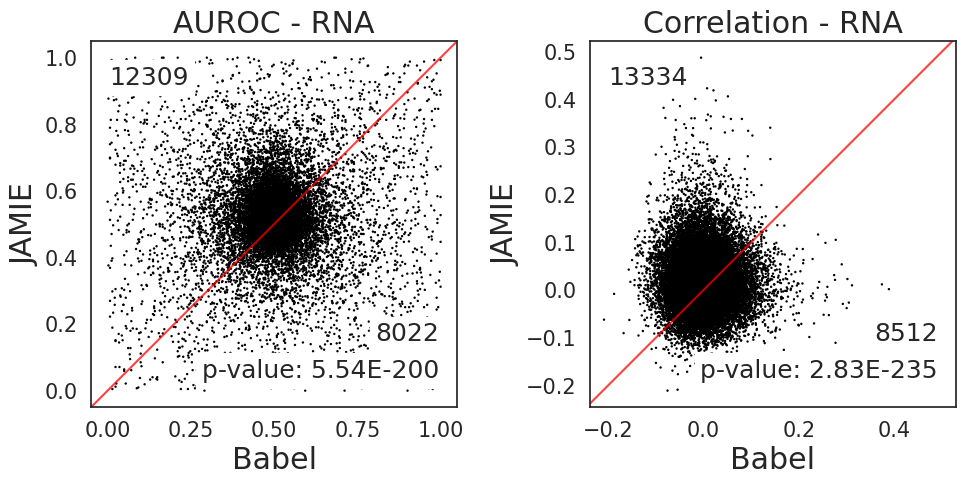

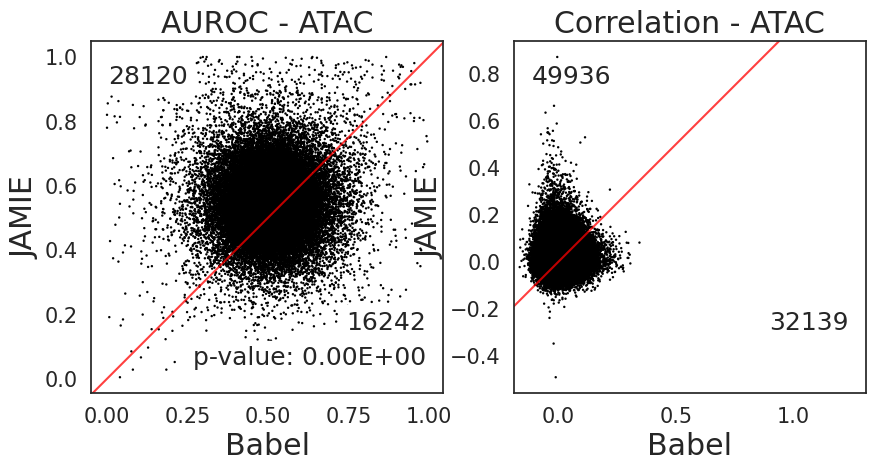

In [11]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp1.png', dpi=300)

plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp2.png', dpi=300)

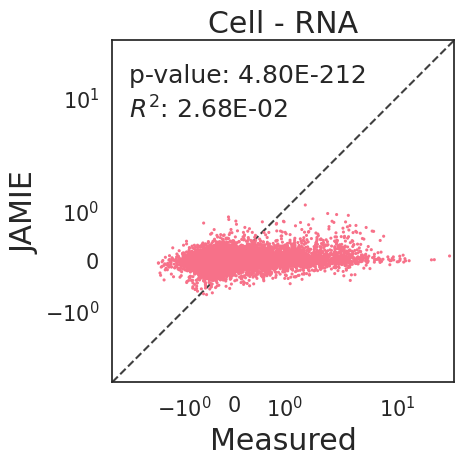

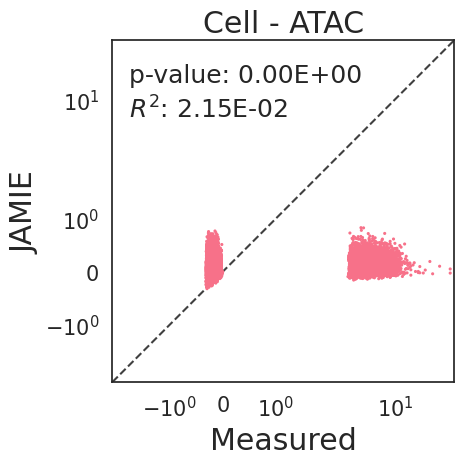

In [11]:
# Choose sample
for modality_idx in range(len(dataset)):
    for i, cell_type in enumerate(np.unique(labels[modality_idx][test_idx])):
        plt.figure(figsize=(5, 5))
        plot_sample(
            np.array([np.array(row) for ct, row in zip(labels[modality_idx][test_idx], dataset[modality_idx][test_idx]) if ct==cell_type]),
            np.array([np.array(row) for ct, row in zip(labels[modality_idx][test_idx], imputed_data[1][modality_idx]) if ct==cell_type]),
            imputed_names[1],
            modality_names[modality_idx],
            suptitle=None,
            color=np.array(plt.rcParams['axes.prop_cycle'])[i]['color'],
            scale='symlog')
        plt.tight_layout()
        plt.savefig(image_folder + dataset_name + f'-Sample{modality_idx}-{cell_type.replace("/", "_")}.png', dpi=300, bbox_inches='tight')
        plt.show()

/home/thema/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


PVT1: 0.4778376187547247
APCDD1: 0.6561669585444838


/home/thema/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


chr20:63449553-63450619: 0.7262829367629149
chr6:16064719-16065052: 0.7031172406403514


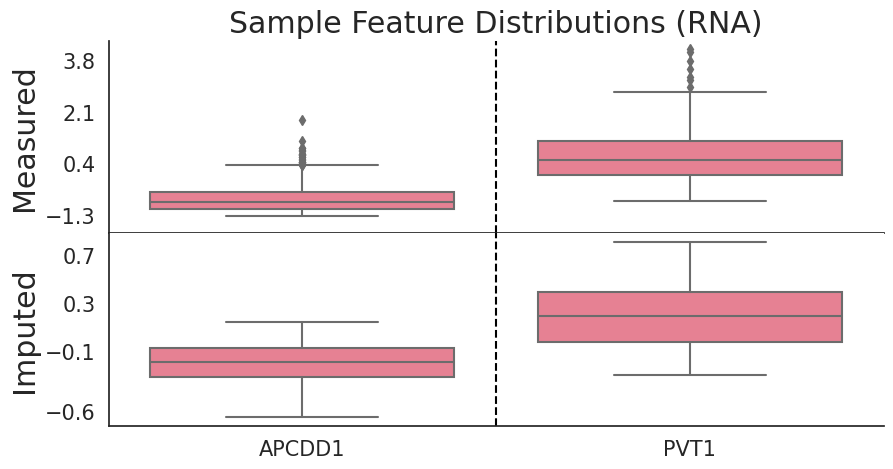

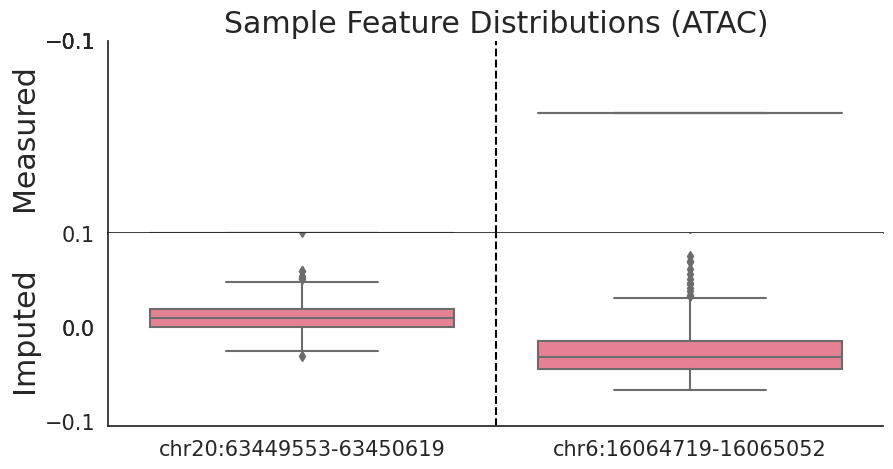

In [12]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], label_order=np.unique(labels), title=modality_names[0], fnames=2*[features[0]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist1.png', dpi=300)

plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1][test_idx], jm_imputed[1][test_idx]], 2*[labels[1][test_idx]], label_order=np.unique(labels), title=modality_names[1], fnames=2*[features[1]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist2.png', dpi=300)

# Explanation

In [11]:
mod0, mod1 = 1, 0
current_jm = jm_im
analysis_base = f'{output_folder}JAMIE---{size_str}---'
analysis_str = analysis_base + 'sorted_genes.pkl'

In [12]:
f'There are {len(np.unique([f.split(":")[0] for f in features[mod0]]))} chromosomes surveyed'

'There are 22 chromosomes surveyed'

Significance between
Within 10kbp and Within 1Mbp: 1.09e-10
Within 10kbp and Same Chromosome: 2.84e-109
Within 10kbp and Genome-Wide: 1.26e-287
Within 1Mbp and Same Chromosome: 3.18e-40
Within 1Mbp and Genome-Wide: 1.66e-104
Same Chromosome and Genome-Wide: 7.46e-01


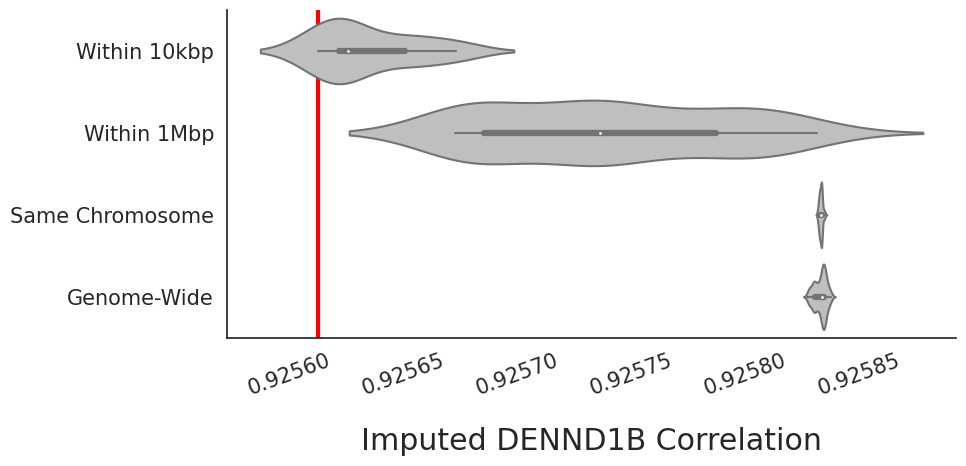

In [13]:
np.random.seed(42)

import pickle
from scipy.stats import pearsonr

# Get target and measurements
target_gene = 'DENND1B'
target_idx = np.argwhere(features[mod1] == target_gene)[0][0]
target_chrom = 1
target_loc = np.array([int(l) for l in '197,504,748-197,782,150'.replace(',', '').split('-')])
chrom = np.array([int(n.split(':')[0][3:]) for n in features[mod0]])
loc = np.array([[int(l) for l in n.split(':')[1].split('-')] for n in features[mod0]])

# Get matches
match_chrom = np.array([c==target_chrom for c in chrom])
threshold = [10_000, 1_000_000]
threshold_str = ['10kbp', '1Mbp']
# np.array([mc and (max(target_loc[0]-threshold, l[0]) <= min(target_loc[1]+threshold, l[1])) for mc, l in zip(match_chrom, loc)])  # Overlap
match_loc = np.array([[mc and target_loc[0]-t <= l[0] and target_loc[1]+t >= l[1] for mc, l in zip(match_chrom, loc)] for t in threshold])

# Get idx
samples = np.array([np.sum(match_loc[0]), 50, 100, 300])
# samples = np.array(4*[10])
within_10kbps = np.random.choice(np.argwhere(match_loc[0]).flatten(), samples[0], replace=False)
within_1Mbps = np.random.choice(np.argwhere(match_loc[1] * ~match_loc[0]).flatten(), samples[1], replace=False)
within_chrom = np.random.choice(np.argwhere(match_chrom * ~match_loc[1]).flatten(), samples[2], replace=False)
within_genome = np.random.choice(np.argwhere(~match_chrom).flatten(), samples[3], replace=False)
idx_list = np.concatenate([within_10kbps, within_1Mbps, within_chrom, within_genome])
name_list = [f'Within {threshold_str[0]}', f'Within {threshold_str[1]}', 'Same Chromosome', 'Genome-Wide']

# Run correlations
def function(x, idx=None):
    return current_jm.modal_predict(x, mod0)[:, target_idx]
true = dataset[mod1][:, target_idx]
perf_function = lambda x, y: pearsonr(x, y)[0]
if not os.path.exists(analysis_str):
    baseline, performance, new_idx = (
        evaluate_impact(
            function,
            perf_function,
            dataset[mod0],
            dataset[mod1][:, target_idx],
            features[mod0],
            idx=idx_list,
            mode='replace'))
    
    with open(analysis_str, 'wb') as f:
        pickle.dump((baseline, performance, new_idx), f)
else:
    with open(analysis_str, 'rb') as f:
        baseline, performance, new_idx = pickle.load(f)

# Calculate p-values
from scipy.stats import ttest_ind
print('Significance between')
p_values = []
for i in range(len(name_list)):
    for j in range(i+1, len(name_list)):
        p_values.append(ttest_ind(
            performance[np.sum(samples[:i]):np.sum(samples[:i+1])],
            performance[np.sum(samples[:j]):np.sum(samples[:j+1])],
            alternative='less')[1])
        print(f'{name_list[i]} and {name_list[j]}: {p_values[-1]:.2e}')

# Vars
x = performance
y = np.concatenate([s*[n] for s, n in zip(samples, name_list)]).flatten()

# Plot
plt.figure(figsize=(10, 5))
# sns.boxplot(x=x, y=y, color='.75')
sns.violinplot(x=x, y=y, color='.75', scale='width', inner='box')
# sns.swarmplot(x=x, y=y, color='0', size=1)
sns.despine()

# Styling
# plt.axvline(x=0, color='red', linewidth=3, zorder=-1)
plt.axvline(x=baseline, color='red', linewidth=3, zorder=-1)
plt.xlabel(f'Imputed {target_gene} Correlation', labelpad=20)
plt.xticks(rotation=20)

# Save
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Analysis.png', dpi=300, bbox_inches='tight')